Tweet Analysis using SimpleRNN, LSTM and GRU

# Introduction

Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

Take an example:
The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.


## NLP
In this notebook I will use NLP methods to clean and tokenize the data and create word embeddings. Word embedings are vector representation of the word in a multi-dimentional space and sutiable as an input for ML models

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM
from keras.layers import Bidirectional

Using TensorFlow backend.


In [2]:
# load train and test datasets
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [3]:
# check the no. of rows and columns in the dataset
print(train.shape, test.shape)
train.head()


(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.isnull().sum().sort_values(ascending = False)

location    2533
keyword       61
target         0
text           0
id             0
dtype: int64

#### We can see a lots of null values for "keyword" and "location" columns

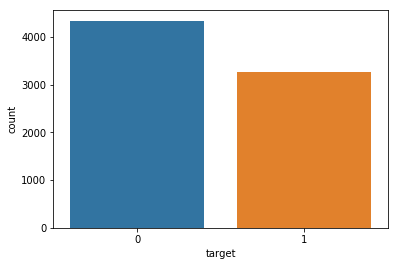

In [5]:
sns.countplot(x=train.target)

#### *The dataset is balanced, also we will not use location or keyword so we can igore the nulls*

### Data Cleaning

In order to get accurate results from the predictive model, we need to remove these stop words & punctuations.

Apart from removing these stopwords & puncuations, we would also convert all the messages in lowercase so that words like "Go" & "go" can be treated as same word and not different words.

We will also convert the words to its lemma form (for example, lemma of word "running" would be run), converting words to their lemmas would also help improving the predictive power of our model.

We would also remove embedded special characters from the tweets, for example, #earthquake should be replaced by earthquake

We also need to remove the "URLs" from the tweets

And then finally we remove the digits from the tweets

Lets write a small function "preprocess" to achive all these tasks.

In [6]:
#lets save stopwords in a variable
stop = list(stopwords.words("english"))
# save list of punctuation/special characters in a variable
punctuation = list(string.punctuation)
# create an object to convert the words to its lemma form
lemma = WordNetLemmatizer()
# lets make a combine list of stopwords and punctuations
sw_pun = stop + punctuation

In [7]:
# print punctuation and stop words.
print(punctuation)
print(stop)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when

In [8]:
# function to preprocess the messages
def preprocess(tweet):
    #tweet = re.sub(r'https?:\/\/(?:www\.)?\S+\.\S+', "", tweet)
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

print(preprocess('this is a link to http://google.ai with 25 @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C redirects'))

link http google bbcmtd wholesale market ablaze redirect 


In [9]:
# apply preprocessing functions on the train and test datasets
train['text'] = train['text'].apply(lambda s : preprocess(s))
test ['text'] = test ['text'].apply(lambda s : preprocess(s))
train.iloc[31]['text']

'bbcmtd wholesale market ablaze '

In [10]:
# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [11]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))
test ['text'] = test ['text'].apply(lambda s : remove_emoji(s))


# Model Building & Evaluation

# Deep Learning Model using Word Embeddings

Another popular and powerful way to associate a vector with a word is the use of dense word vectors, also called `word embeddings`. 

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. It’s effectively a dictionary lookup.

Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are low dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vectors); 

Unlike the word vectors obtained via one-hot encoding, word embeddings are learned from data. It’s common to see word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies. 

On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or greater (capturing a vocabulary of 6,025 tokens, above). So, word embeddings pack more information into far fewer dimensions.

we will load into your model word embeddings that were precomputed using a different machine-learning task than the one you’re trying to solve. These are called
pretrained word embeddings.

In [12]:
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)
# lets check the no. of the words in the final vocabulary
vocab_size = len(final_vocab)
vocab_size

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


6025

In [13]:
# Number of words to consider as features
max_features = vocab_size

# Cuts off the text after this number of words (among the max_features most common words)
maxlen = 130


In [14]:
print(max([len(s) for s in train.text]))
print(train.shape)


134
(7613, 5)


In [15]:
# the different units into which you can break down text (words, characters, or n-grams) are called tokens, 
# and breaking text into such tokens is called tokenization, this can be achieved using Tokenizer in Keras

from keras.preprocessing.text import Tokenizer
# fit a tokenizer
def create_tokenizer(lines):
    # num_words = vocab_size will create a tokenizer,configured to only take into account the vocab_size(6025)
    tokenizer = Tokenizer(num_words=vocab_size)
    # Build th word index, Turns strings into lists of integer indices
    tokenizer.fit_on_texts(lines) 
    return tokenizer

In [16]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [17]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(train.text)

In [18]:
from keras import preprocessing
# conver text to sequences
sequences = tokenizer.texts_to_sequences(train.text)
print(len(sequences))

7613


In [19]:
# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen), padding shorter sequences with 0s
train_text = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

In [20]:
train_text.shape

(7613, 130)

In [21]:
# Test train split 
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train_text, train.target, test_size = 0.2, random_state = 42)

In [22]:
X_train_1.shape

(6090, 130)

### 1. Neural Network with Embedding Layer

In [23]:
# build the model
model = Sequential()
# Specifies the maximum input length to the Embedding layer so you can later flatten the embedded inputs. 

# After the Embedding layer, the activations have shape (samples, maxlen, 8)
model.add(Embedding(vocab_size, 8, input_length=maxlen))

# Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(64))
# Dense layer for classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[get_f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 8)            48200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1040)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                33312     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 83,689
Trainable params: 83,689
Non-trainable params: 0
_________________________________________________________________


In [24]:
callbacks_list = [
    EarlyStopping(
        monitor='get_f1',
        patience=1,
    ),
    ModelCheckpoint(filepath='./embd.h5',monitor='val_loss',save_best_only=True)
]

In [25]:
# train the model
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=32,
callbacks=callbacks_list,
validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 1s 268us/step - loss: 0.6386 - get_f1: 0.2654 - val_loss: 0.5226 - val_get_f1: 0.6273
Epoch 2/100
4872/4872 [==============================] - 0s 89us/step - loss: 0.4114 - get_f1: 0.7664 - val_loss: 0.4958 - val_get_f1: 0.7211


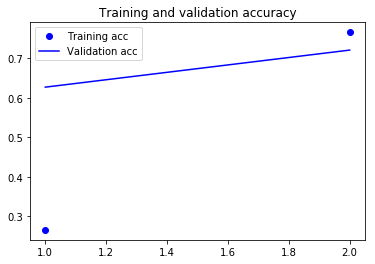

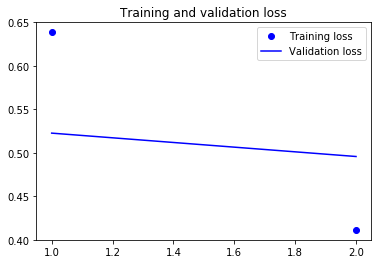

In [26]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
import keras
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_embd = keras.models.load_model('./embd.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
# prediction on the test dataset
y_pred_1 = loaded_model_embd.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       874
           1       0.75      0.71      0.73       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



We got to a f1 score of 81%, which is pretty good considering its a simple deep learning model. But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). 

We will try RNN and LSTMs next

In [29]:
# convert text to sequences
sequences = tokenizer.texts_to_sequences(test.text)
# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
test_text = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

In [30]:
# make predictions on the test dataset
test_id = test.id

y_test_pred = loaded_model_embd.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [31]:
sub.to_csv('submission_embedding.csv',index=False)

### 3. Neural Network with pre trained Embedding Layer(GLOVE)

In [32]:
# Considers only the top 10000 words in the dataset
max_words = 10000
word_index = tokenizer.word_index
print(list(word_index.items())[:10])

[('like', 1), ('fire', 2), ('bomb', 3), ('news', 4), ('people', 5), ('burn', 6), ('time', 7), ('kill', 8), ('make', 9), ('flood', 10)]


We’ll build an embedding matrix that you can load into an Embedding layer. 

It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index (built during tokenization). 

Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholde

In [33]:
import os
glove_dir = "../input/glove6b100dtxt/"
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [34]:
!cat ../input/glove6b100dtxt/glove.6B.100d.txt |wc

 400000 40400000 347116733


In [35]:
max_words


10000

In [36]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the embedding index will be all zeros.

In [54]:
# lets use the same model architecture we used earlier
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 13000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                416032    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,420,257
Trainable params: 1,420,257
Non-trainable params: 0
____________________________________________

### LOADING THE GLOVE EMBEDDINGS IN THE MODEL

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. 

Load the GloVe matrix we prepared into the Embedding layer, the first layer in the model

In [55]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [56]:
# Compile the model
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

In [57]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./pre_embd.h5',monitor='val_loss',save_best_only=True)
]

In [58]:
# train the model
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=32,
callbacks=callbacks_list,
validation_split=0.2)

Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 1s 148us/step - loss: 0.5117 - get_f1: 0.6918 - val_loss: 0.4819 - val_get_f1: 0.7219
Epoch 2/100
4872/4872 [==============================] - 0s 96us/step - loss: 0.4082 - get_f1: 0.7767 - val_loss: 0.5356 - val_get_f1: 0.7264


We see that the model starts overfitting after the second epoch. 

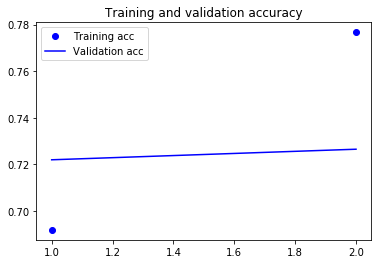

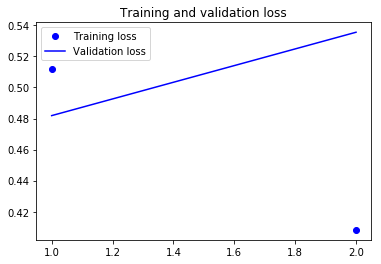

In [59]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [60]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_pre_embd = keras.models.load_model('./pre_embd.h5',custom_objects=dependencies)

In [61]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_pre_embd.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.70      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [62]:
# make predictions on the test dataset
y_test_pred = loaded_model_pre_embd.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [63]:
sub.to_csv('submission_pre_embedding.csv',index=False)

Embedding layer that learnt embeddings with the model training proved to be better than pre trained embedding.

### 4.SIMPLE RNN

In [64]:
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [111]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./SRNN.h5',monitor='val_loss',save_best_only=True)
]

In [112]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[get_f1])

history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 2s 426us/step - loss: 0.6559 - get_f1: 0.3626 - val_loss: 0.6530 - val_get_f1: 0.1927
Epoch 2/100
4872/4872 [==============================] - 2s 333us/step - loss: 0.5188 - get_f1: 0.6822 - val_loss: 0.5523 - val_get_f1: 0.5557


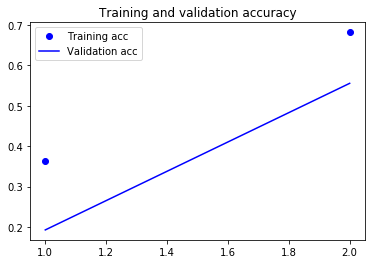

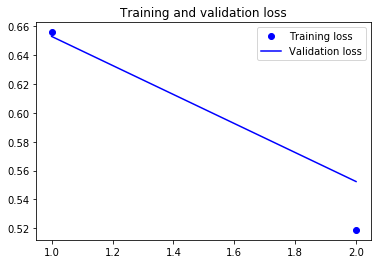

In [115]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [116]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_SRNN = keras.models.load_model('./SRNN.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [144]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_SRNN.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       874
           1       0.93      0.37      0.53       649

    accuracy                           0.72      1523
   macro avg       0.81      0.68      0.67      1523
weighted avg       0.79      0.72      0.69      1523



In [118]:
# make predictions on the test dataset
y_test_pred = loaded_model_SRNN.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [119]:
sub.to_csv('submission_SRNN.csv',index=False)

Model's performance not yet improved, lets stack some layers.

### 5. Stack multiple SimpleRNN layers

In [124]:
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32,return_sequences=True))
#model.add(SimpleRNN(32,return_sequences=True))
#model.add(SimpleRNN(32,return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 164,193
Trainable params: 164,193
Non-trainable params: 0
_________________________________________________________________


In [125]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./STRNN.h5',monitor='val_loss',save_best_only=True)
]

In [139]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[get_f1])

history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 4s 849us/step - loss: 0.6487 - get_f1: 0.1802 - val_loss: 0.6032 - val_get_f1: 0.5338
Epoch 2/100
4872/4872 [==============================] - 4s 732us/step - loss: 0.5409 - get_f1: 0.6506 - val_loss: 0.5237 - val_get_f1: 0.7231


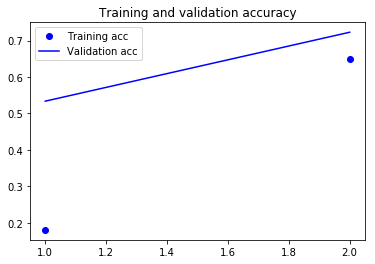

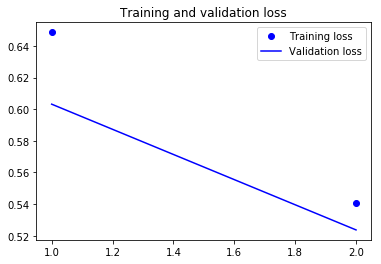

In [140]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [141]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_STRNN = keras.models.load_model('./STRNN.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [145]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_STRNN.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.95      0.73       874
           1       0.62      0.11      0.19       649

    accuracy                           0.59      1523
   macro avg       0.61      0.53      0.46      1523
weighted avg       0.60      0.59      0.50      1523



In [131]:
# make predictions on the test dataset
y_test_pred = loaded_model_STRNN.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
sub.to_csv('submission_stackRNN.csv',index=False)

Didn't help, lets try LSTM

### 6. LSTM

In [132]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))


In [133]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

In [134]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./LSTM.h5',monitor='val_loss',save_best_only=True)
]

In [146]:
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 4s 728us/step - loss: 0.4204 - get_f1: 0.7830 - val_loss: 0.4898 - val_get_f1: 0.7476
Epoch 2/100
4872/4872 [==============================] - 4s 736us/step - loss: 0.3434 - get_f1: 0.8239 - val_loss: 0.4817 - val_get_f1: 0.7504


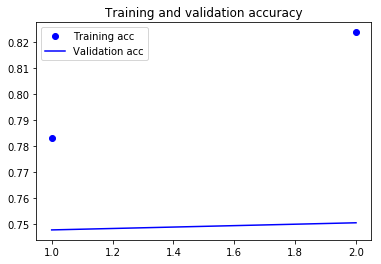

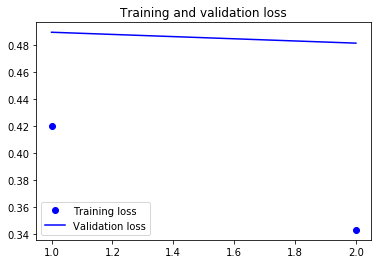

In [147]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [148]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_LSTM = keras.models.load_model('./LSTM.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [149]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_LSTM.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       874
           1       0.72      0.77      0.74       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.77      0.77      1523



In [150]:
# make predictions on the test dataset
y_test_pred = loaded_model_LSTM.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [151]:
sub.to_csv('LSTM.csv',index=False)

LSTM doing a decent job here, lets try Bi directional LSTM

### 7. Bi-Direction LSTM

In [152]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

In [153]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

In [154]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./BILSTM.h5',monitor='val_loss',save_best_only=True)
]

In [155]:
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 26s 5ms/step - loss: 0.6370 - get_f1: 0.2716 - val_loss: 0.4942 - val_get_f1: 0.7310
Epoch 2/100
4872/4872 [==============================] - 22s 5ms/step - loss: 0.4053 - get_f1: 0.7957 - val_loss: 0.5441 - val_get_f1: 0.7443


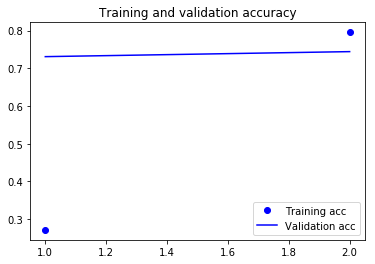

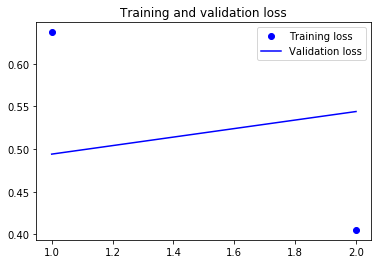

In [156]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [157]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_BILSTM = keras.models.load_model('./BILSTM.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [159]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_BILSTM.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       874
           1       0.76      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [160]:
# make predictions on the test dataset
y_test_pred = loaded_model_BILSTM.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [162]:
sub.to_csv('BiLSTM.csv',index=False)

Neural Network with Embedding layer seems to the best model for this classification task.

# Please upvote if you like this kernel.

# GRU

In [163]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

In [164]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

In [165]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./GRU.h5',monitor='val_loss',save_best_only=True)
]

In [166]:
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 4s 829us/step - loss: 0.6514 - get_f1: 0.1548 - val_loss: 0.6011 - val_get_f1: 0.4468
Epoch 2/100
4872/4872 [==============================] - 3s 712us/step - loss: 0.5170 - get_f1: 0.6958 - val_loss: 0.4995 - val_get_f1: 0.7155


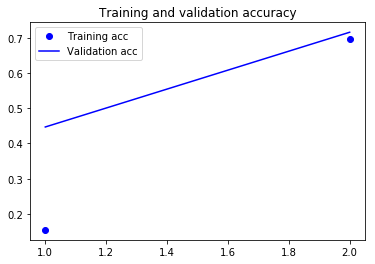

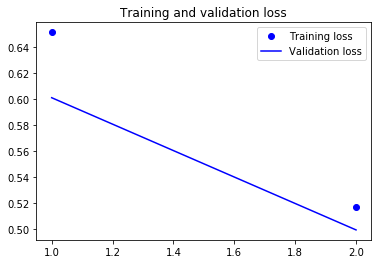

In [167]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [168]:
dependencies = {
    'get_f1': get_f1
}

# load the model from disk
loaded_model_GRU = keras.models.load_model('./GRU.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [169]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_GRU.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       874
           1       0.81      0.63      0.71       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



In [ ]:
# make predictions on the test dataset
y_test_pred = loaded_model_GRU.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

In [170]:
sub.to_csv('GRU.csv',index=False)

# Stacked GRU

In [171]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

In [172]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

In [173]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./SGRU.h5',monitor='val_loss',save_best_only=True)
]

In [175]:
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 14s 3ms/step - loss: 0.5970 - get_f1: 0.4182 - val_loss: 0.5417 - val_get_f1: 0.7151
Epoch 2/100
4872/4872 [==============================] - 14s 3ms/step - loss: 0.4024 - get_f1: 0.7849 - val_loss: 0.5073 - val_get_f1: 0.7095


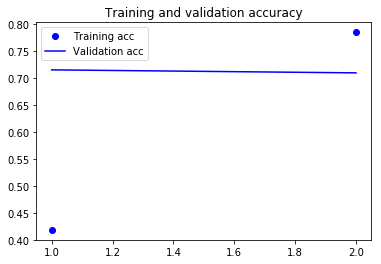

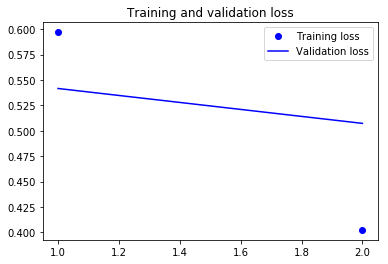

In [176]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [177]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_SGRU = keras.models.load_model('./SGRU.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [180]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_SGRU.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.84       874
           1       0.85      0.62      0.72       649

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.78      1523



In [181]:
# make predictions on the test dataset
y_test_pred = loaded_model_SGRU.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [182]:
sub.to_csv('SGRU.csv',index=False)

# Stacked GRU with Dropouts

In [42]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

In [44]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./DSGRU.h5',monitor='val_loss',save_best_only=True)
]

In [45]:
history = model.fit(X_train_1, y_train_1,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 32s 6ms/step - loss: 0.6697 - get_f1: 0.1293 - val_loss: 0.6137 - val_get_f1: 0.6225
Epoch 2/100
4872/4872 [==============================] - 29s 6ms/step - loss: 0.4888 - get_f1: 0.7172 - val_loss: 0.5052 - val_get_f1: 0.6717


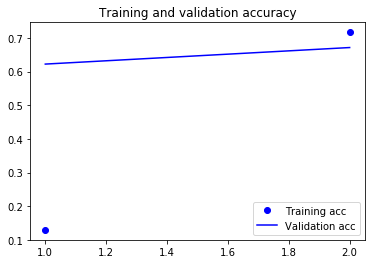

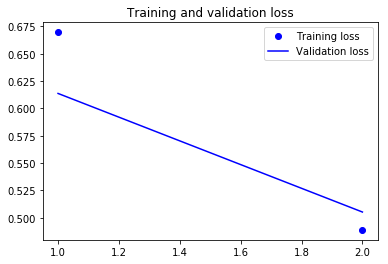

In [46]:
# check model performance
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
dependencies = {
    'get_f1': get_f1
}


# load the model from disk
loaded_model_DSGRU = keras.models.load_model('./DSGRU.h5',custom_objects=dependencies)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [48]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = loaded_model_DSGRU.predict_classes(X_test_1)

# important metrices
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.83       874
           1       0.86      0.56      0.68       649

    accuracy                           0.77      1523
   macro avg       0.80      0.75      0.75      1523
weighted avg       0.79      0.77      0.76      1523



In [49]:
# make predictions on the test dataset
y_test_pred = loaded_model_DSGRU.predict_classes(test_text)

# lets prepare for the prediction submission
sub = pd.DataFrame()
sub['Id'] = test_id
sub['target'] = y_test_pred
sub.head()

,Id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [50]:
sub.to_csv('GRUDropOut.csv',index=False)

### Hyperparameter Tuning
We did not substancially imporove with the dropouts. We will use Stacked GRU but experiment with learning rates.

In [85]:
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

#custom_optimizer = Adam(learning_rate=0.0001)
custom_optimizer = RMSprop(learning_rate=0.0005)

model.compile(optimizer= custom_optimizer, #'rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

callbacks_list = [
    EarlyStopping(
    monitor='get_f1',
    patience=1,
),
ModelCheckpoint(filepath='./SGRU1.h5',monitor='val_loss',save_best_only=True)
]

history = model.fit(X_train_1, y_train_1,
    epochs=100,
    batch_size=128,
    callbacks=callbacks_list,
    validation_split=0.2)



Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 20s 4ms/step - loss: 0.6638 - get_f1: 0.0865 - val_loss: 0.6427 - val_get_f1: 0.2893
Epoch 2/100


/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


4872/4872 [==============================] - 18s 4ms/step - loss: 0.5356 - get_f1: 0.6500 - val_loss: 0.5127 - val_get_f1: 0.6815


In [86]:
y_pred = model.predict_classes(X_test_1)
print(classification_report(y_test_1, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.91      0.83       874
           1       0.83      0.61      0.70       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.76      1523
weighted avg       0.79      0.78      0.77      1523



## Reducing the learnign rate does not lead to much improvement. Maybe we are overfitting. Lets try a model with fewer layers

In [40]:
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32,return_sequences=True))
#model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer= 'rmsprop',
loss='binary_crossentropy',
metrics=[get_f1])

callbacks_list = [
    EarlyStopping(
    monitor='get_f1',
    patience=1,
),
ModelCheckpoint(filepath='./SGRU1.h5',monitor='val_loss',save_best_only=True)
]

history = model.fit(X_train_1, y_train_1,
    epochs=100,
    batch_size=128,
    callbacks=callbacks_list,
    validation_split=0.2)

y_pred = model.predict_classes(X_test_1)
print(classification_report(y_test_1, y_pred))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4872 samples, validate on 1218 samples
Epoch 1/100
4872/4872 [==============================] - 10s 2ms/step - loss: 0.6218 - get_f1: 0.3584 - val_loss: 0.5363 - val_get_f1: 0.7165
Epoch 2/100
4872/4872 [==============================] - 9s 2ms/step - loss: 0.4162 - get_f1: 0.7751 - val_loss: 0.4793 - val_get_f1: 0.7250
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       874
           1       0.77      0.70      0.74       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



#### Reducing the no of layers does not seem to impact the score much. 

### Obersavtions and conclusions

The LSTM and GRU models seem to perform the best. Hyperparameter tuning does not seem to yield in any better performance. I think this is because the small size of the dataset compared to the parameters being trained. I submitted GRU with droupout as the final model.